In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install scanpy --quiet

     |████████████████████████████████| 2.0 MB 15.3 MB/s 
     |████████████████████████████████| 96 kB 5.4 MB/s 
     |████████████████████████████████| 88 kB 8.1 MB/s 
     |████████████████████████████████| 9.4 MB 60.5 MB/s 
     |████████████████████████████████| 295 kB 66.3 MB/s 
     |████████████████████████████████| 965 kB 83.4 MB/s 
     |████████████████████████████████| 1.1 MB 83.9 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 


In [3]:
!pip install matplotlib==3.4 --quiet

     |████████████████████████████████| 10.3 MB 11.6 MB/s 


In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import copy
import h5py
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
import gc

from scipy import sparse
from collections import Counter

In [ ]:
adata = ad.read_h5ad("drive/MyDrive/Colab_Notebooks/CPSC532S/final_project/data/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")

In [ ]:
adata

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [ ]:
adata.X[:10,:10].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 2.194758  ],
       [0.41061893, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.27813566,
        0.5562713 , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [ ]:
adata.var['feature_types'].value_counts()

ATAC    116490
GEX      13431
Name: feature_types, dtype: int64

In [ ]:
adata.layers['counts'].get_shape()

(69249, 129921)

In [ ]:
adata.layers['counts'][:10,:10].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# Process and store GEX AnnData

In [ ]:
adata_gex = adata[:, adata.var.feature_types=="GEX"].copy()

In [ ]:
adata_gex

Remove the metadata related to ATAC for GEX data:

In [ ]:
for key in ['ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal']:
  adata_gex.obs.pop(key)

In [ ]:
for key in ['ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap']:
  adata_gex.obsm.pop(key)

In [ ]:
adata_gex

AnnData object with n_obs × n_vars = 69249 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [ ]:
adata_gex.X

<69249x13431 sparse matrix of type '<class 'numpy.float32'>'
	with 76997578 stored elements in Compressed Sparse Row format>

In [ ]:
adata_gex.X[:10,:10].todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 2.194758  ],
        [0.41061893, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.27813566,
         0.5562713 , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.    

In [ ]:
adata_gex.layers['counts'][:10,:10].todense()

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
adata_gex.layers['log_norm'] = sparse.csr_matrix(np.log(adata_gex.X.todense() + 1))

In [ ]:
adata_gex.layers['log_norm'][:10,:10].todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 1.1615113 ],
        [0.34402853, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.24540251,
         0.44229275, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.    

Write out processed GEX data:

In [ ]:
ad.AnnData.write(adata_gex, "drive/MyDrive/Colab_Notebooks/CPSC532S/final_project/data/GEX_processed.h5ad")

In [ ]:
del(adata_gex)

# Process and store ATAC data

In [ ]:
adata_atac = adata[:, adata.var.feature_types=="ATAC"]

In [ ]:
adata_atac

View of AnnData object with n_obs × n_vars = 69249 × 116490
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [ ]:
# del adata
# gc.collect()

In [ ]:
adata_atac.var['feature_types'].shape

(116490,)

In [ ]:
for key in ['GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase']:
  adata_atac.obs.pop(key)

In [ ]:
for key in ['gene_id']:
  adata_atac.var.pop(key)

In [ ]:
for key in ['GEX_X_pca', 'GEX_X_umap']:
  adata_atac.obsm.pop(key)

In [ ]:
adata_atac.layers['counts']

<69249x116490 sparse matrix of type '<class 'numpy.float32'>'
	with 248342179 stored elements in Compressed Sparse Row format>

In [ ]:
adata_atac.X[:10,:10].todense()

matrix([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
features = adata_atac.var['feature_types'].index
print(features)

Index(['chr1-9776-10668', 'chr1-180726-181005', 'chr1-181117-181803',
       'chr1-191133-192055', 'chr1-267562-268456', 'chr1-629497-630394',
       'chr1-633515-634474', 'chr1-778276-779191', 'chr1-816868-817761',
       'chr1-822804-823597',
       ...
       'GL000195.1-137376-138301', 'GL000219.1-39933-40839',
       'GL000219.1-42172-43054', 'GL000219.1-44703-45584',
       'GL000219.1-45726-46450', 'GL000219.1-90062-90937',
       'GL000219.1-99257-100160', 'KI270726.1-27152-28034',
       'KI270713.1-21434-22336', 'KI270713.1-29629-30491'],
      dtype='object', length=116490)


In [ ]:
seqnames = [feature.split('-')[0] for feature in features]
Counter(seqnames)

Counter({'chr1': 11497,
         'chr10': 5449,
         'chr11': 5833,
         'chr12': 5937,
         'chr13': 2587,
         'chr14': 3938,
         'chr15': 3898,
         'chr16': 4350,
         'chr17': 6256,
         'chr18': 2192,
         'chr19': 5386,
         'chr2': 9123,
         'chr20': 3463,
         'chr21': 1426,
         'chr22': 2887,
         'chr3': 7241,
         'chr4': 4443,
         'chr5': 5573,
         'chr6': 7152,
         'chr7': 5684,
         'chr8': 4605,
         'chr9': 4789,
         'chrX': 2756,
         'chrY': 3,
         'GL000205.2': 9,
         'GL000195.1': 4,
         'GL000219.1': 6,
         'KI270726.1': 1,
         'KI270713.1': 2})

Remove chromosomes with few peaks: 'chrY', 'GL000205.2', 'GL000195.1', 'GL000219.1', 'KI270726.1', 'KI270713.1'



In [ ]:
chrs_rm = ['chrY', 'GL000205.2', 'GL000195.1', 'GL000219.1', 'KI270726.1', 'KI270713.1']
index_rm = [i for i, seqname in enumerate(seqnames) if seqname not in chrs_rm]

In [ ]:
adata_atac = adata_atac[:, index_rm]

In [ ]:
ad.AnnData.write(adata_atac, "drive/MyDrive/Colab_Notebooks/CPSC532S/final_project/data/ATAC_interim.h5ad")

TF-IDF transformation on ATAC data:

In [ ]:
adata_atac = ad.read_h5ad("drive/MyDrive/Colab_Notebooks/CPSC532S/final_project/data/ATAC_interim.h5ad")

In [ ]:
def compute_idf(X):
    return X.shape[0] / X.sum(axis=0)

def tfidf_and_norm(X, idf):
    r"""
    TF-IDF and normalization (following the Seurat v3 approach)
    Parameters
    ----------
    X
        Input matrix
    idf 
        output from idf(X)
    Returns
    -------
    X_norm
        TF-IDF transformed and normalized matrix
    """
    if sparse.issparse(X):
        tf = X.multiply(1 / X.sum(axis=1))
        tfidf = tf.multiply(idf)
    else:
        tf = X / X.sum(axis=1, keepdims=True)
        tfidf = tf * idf

    # normalizer = preprocessing.Normalizer(norm = "l1")
    # X_norm = normalizer.fit_transform(tfidf)
    # X_norm = np.log1p(X_norm * 1e4)

    X_norm = np.log1p(tfidf.multiply(1e4))

    return X_norm

Store IDF into ATAC annData object:

In [ ]:
idf = compute_idf(adata_atac.X)

In [ ]:
adata_atac.var['idf'] = np.asarray(idf).squeeze()

Apply normalization to TF-IDF transformed X:

In [ ]:
adata_atac.layers['log_norm'] = tfidf_and_norm(adata_atac.X, idf)

In [ ]:
ad.AnnData.write(adata_atac, "drive/MyDrive/Colab_Notebooks/CPSC532S/final_project/data/ATAC_processed.h5ad")

Distribution of non-zero values in a cell:

In [ ]:
adata_atac = ad.read_h5ad("drive/MyDrive/Colab_Notebooks/CPSC532S/final_project/data/ATAC_processed.h5ad")

In [ ]:
cell = np.asarray(adata_atac.layers['log_norm'][0].todense())[0]
print(cell)

[0. 0. 0. ... 0. 0. 0.]


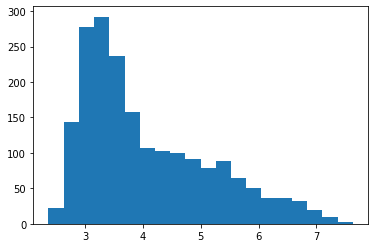

In [ ]:
cell_nonz = [a for a in cell if a > 0]
plt.hist(cell_nonz, bins=20)
plt.show()

In [5]:
batch_gex = ad.read_h5ad("drive/MyDrive/Colab_Notebooks/CPSC532S/final_project/data/GEX_processed.h5ad").obs['batch']

In [6]:
batch_gex

TAGTTGTCACCCTCAC-1-s1d1     s1d1
CTATGGCCATAACGGG-1-s1d1     s1d1
CCGCACACAGGTTAAA-1-s1d1     s1d1
TCATTTGGTAATGGAA-1-s1d1     s1d1
ACCACATAGGTGTCCA-1-s1d1     s1d1
                            ... 
AAACCGCGTTTGAGGC-12-s4d9    s4d9
TGACTTAAGTTCCCGT-12-s4d9    s4d9
GCTGTACCACCGTTCC-12-s4d9    s4d9
ACACTTGCAACTAGAA-12-s4d9    s4d9
CACTTAAAGTCTGGGC-12-s4d9    s4d9
Name: batch, Length: 69249, dtype: category
Categories (13, object): ['s1d1', 's1d2', 's1d3', 's2d1', ..., 's3d10', 's4d1', 's4d8', 's4d9']

In [8]:
from collections import Counter
Counter(batch_gex)

Counter({'s1d1': 6224,
         's1d2': 6740,
         's1d3': 4279,
         's2d1': 4220,
         's2d4': 6111,
         's2d5': 4895,
         's3d3': 4325,
         's3d6': 1679,
         's3d7': 1771,
         's3d10': 6781,
         's4d1': 8023,
         's4d8': 9876,
         's4d9': 4325})